In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [5]:
forecasting_horizon = 30

nb_windows = 15
step_size = 13

lags = [1, 2, 6, 7, 13, 14, 28, 30, 31]
date_features = ["day", "day_of_week", "week_of_year", "month"]

regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED, n_jobs=-1),
                      GradientBoostingRegressor(random_state=SEED)]
regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor"]
save_path="lab/models_skforecast/daily/"

In [6]:
def load_and_preprocess_daily_data(start_index, end_index, date_features):
    index_type = "DatetimeIndex"
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="D", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index)
    co2_df = icap_provider.get_series(icap_tickers[0], index_type=index_type, freq="D", start_index=start_index, end_index=end_index)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
    lags = []

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)

    data_train = df_date_features.iloc[:-forecasting_horizon, :].copy()
    data_test = df_date_features.iloc[-forecasting_horizon:, :].copy()

    initial_window_length = len(data_train) - step_size*(nb_windows-1)

    return data_train, data_test, initial_window_length

## Prepandemic

In [7]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2018-04-01", end_index="2020-03-31", date_features=date_features)
print(initial_window_length)

519


weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


Model: KNeighborsRegressor
MASEs: [1.4001258922935378, 2.033154254900264, 1.5180237382504205, 0.8831272868520325, 0.7156064303042194, 1.147663248691367, 1.4259825562877146, 1.5325518228864439, 1.4535071562898578, 2.2499001544945836, 3.310072681167359, 3.892465626652399, 2.636895237046261, 2.9304025732449377, 3.2360448060721776]
MAEs: [4.845702777777778, 6.9568708333333324, 5.154545833333333, 3.0055500000000004, 2.4279361111111095, 3.8894361111111104, 4.818441666666667, 5.2076013888888895, 4.970272222222222, 7.734488888888889, 11.386513888888885, 13.63328888888889, 9.262788888888888, 10.219702777777778, 11.313315277777779]
Fit time: 0.2644624710083008

Model: RandomForestRegressor
MASEs: [1.3208465937667655, 1.6604351439915934, 1.5190118740590421, 1.1730833643474037, 1.3883549243743123, 0.9771381116288613, 0.9204495447935015, 0.9394835130368346, 0.8450102012378486, 1.2640087181126984, 2.0673115107555056, 2.3783704740067457, 1.9078153559977742, 2.493923386389175, 2.825607085985569]
MAEs:

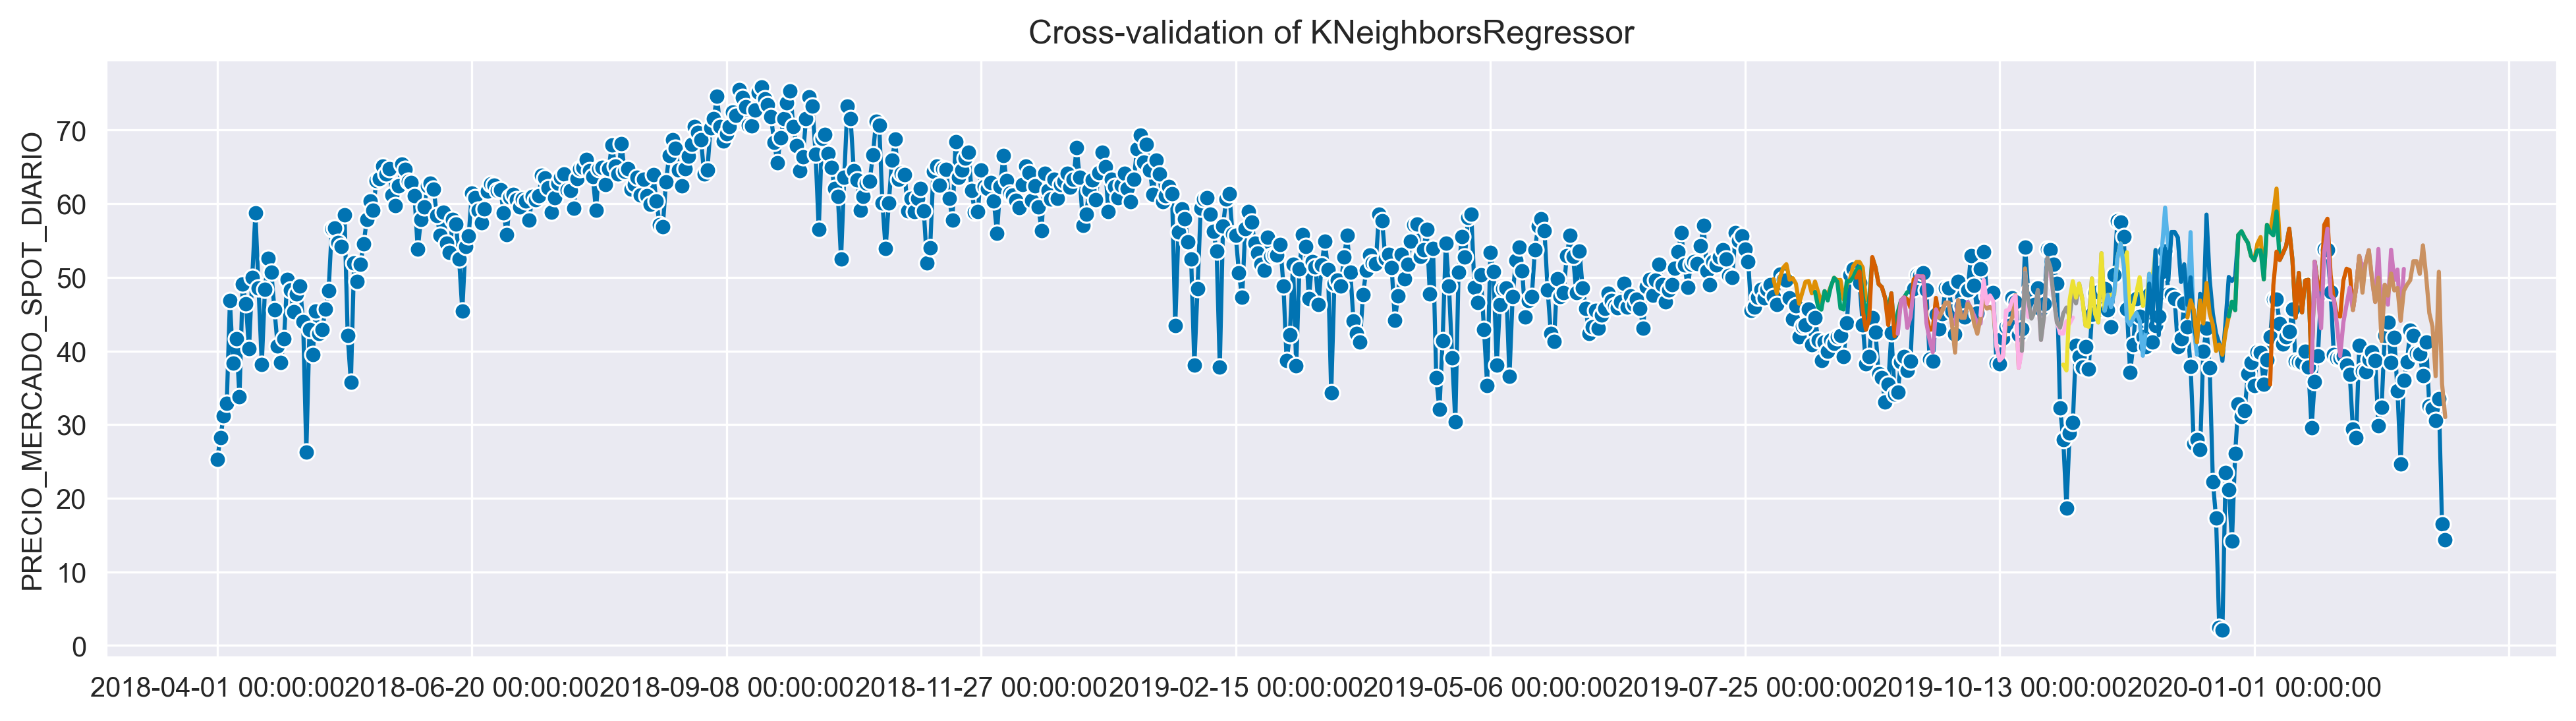

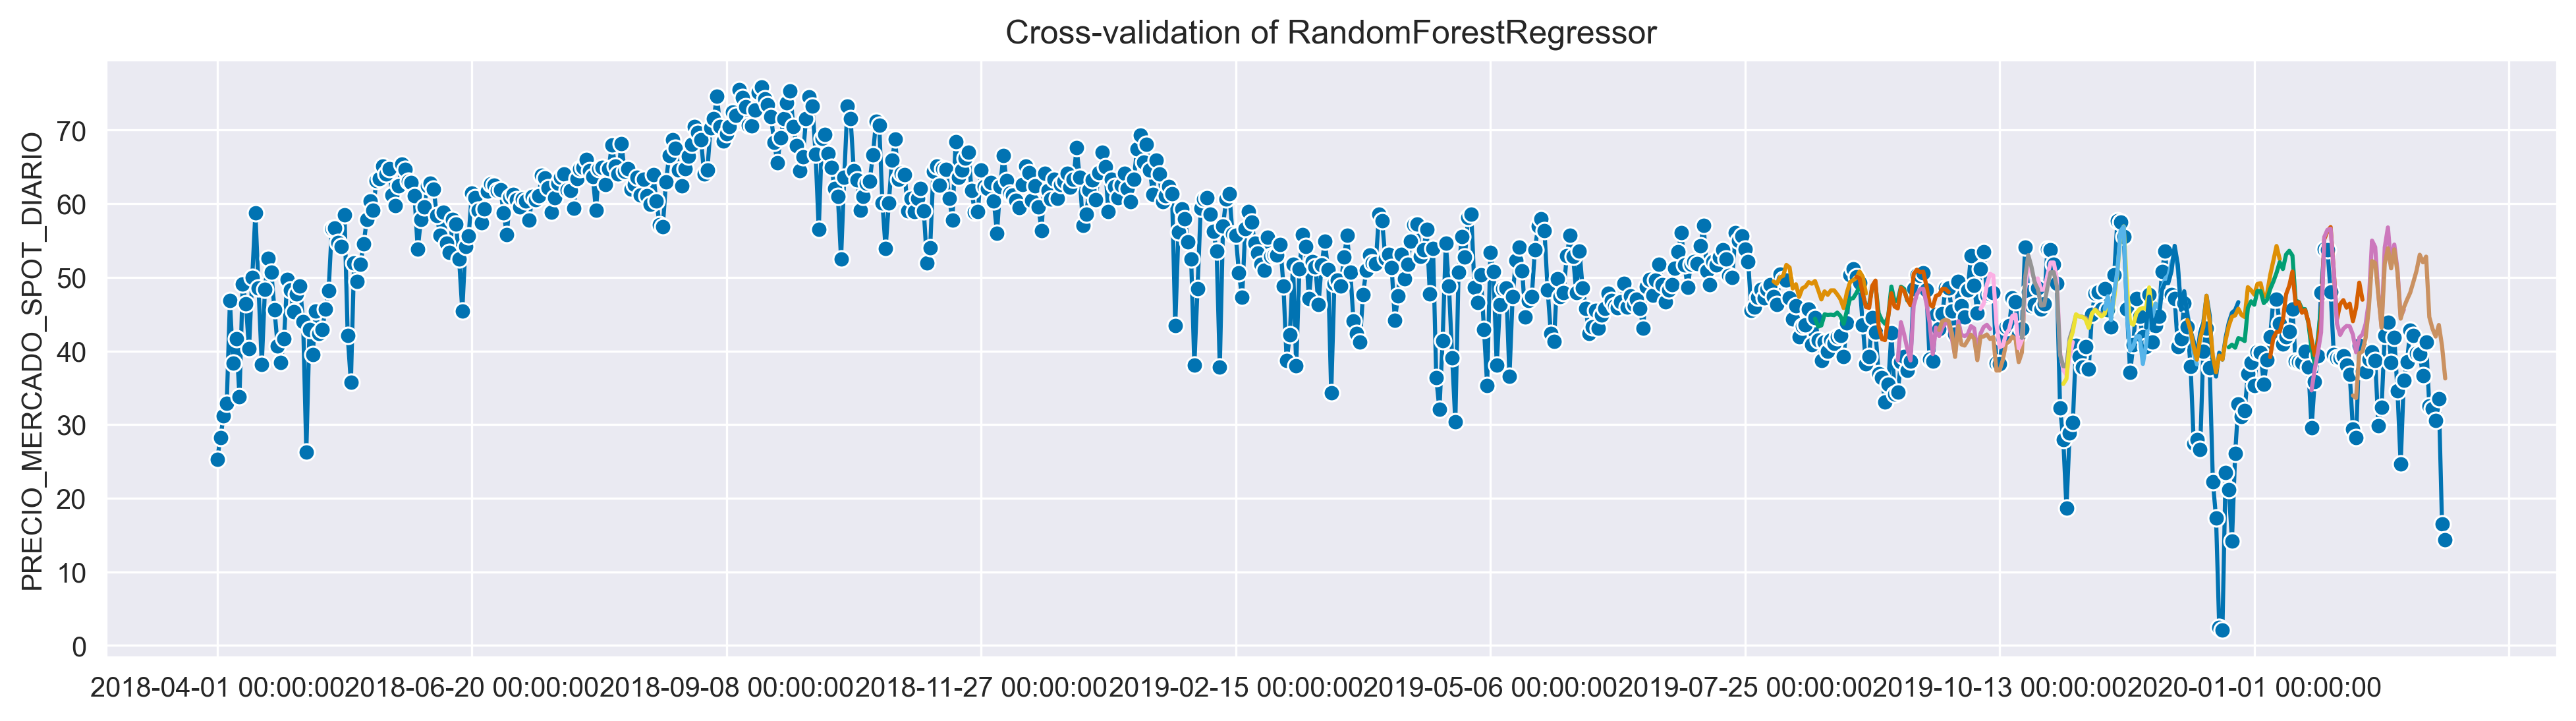

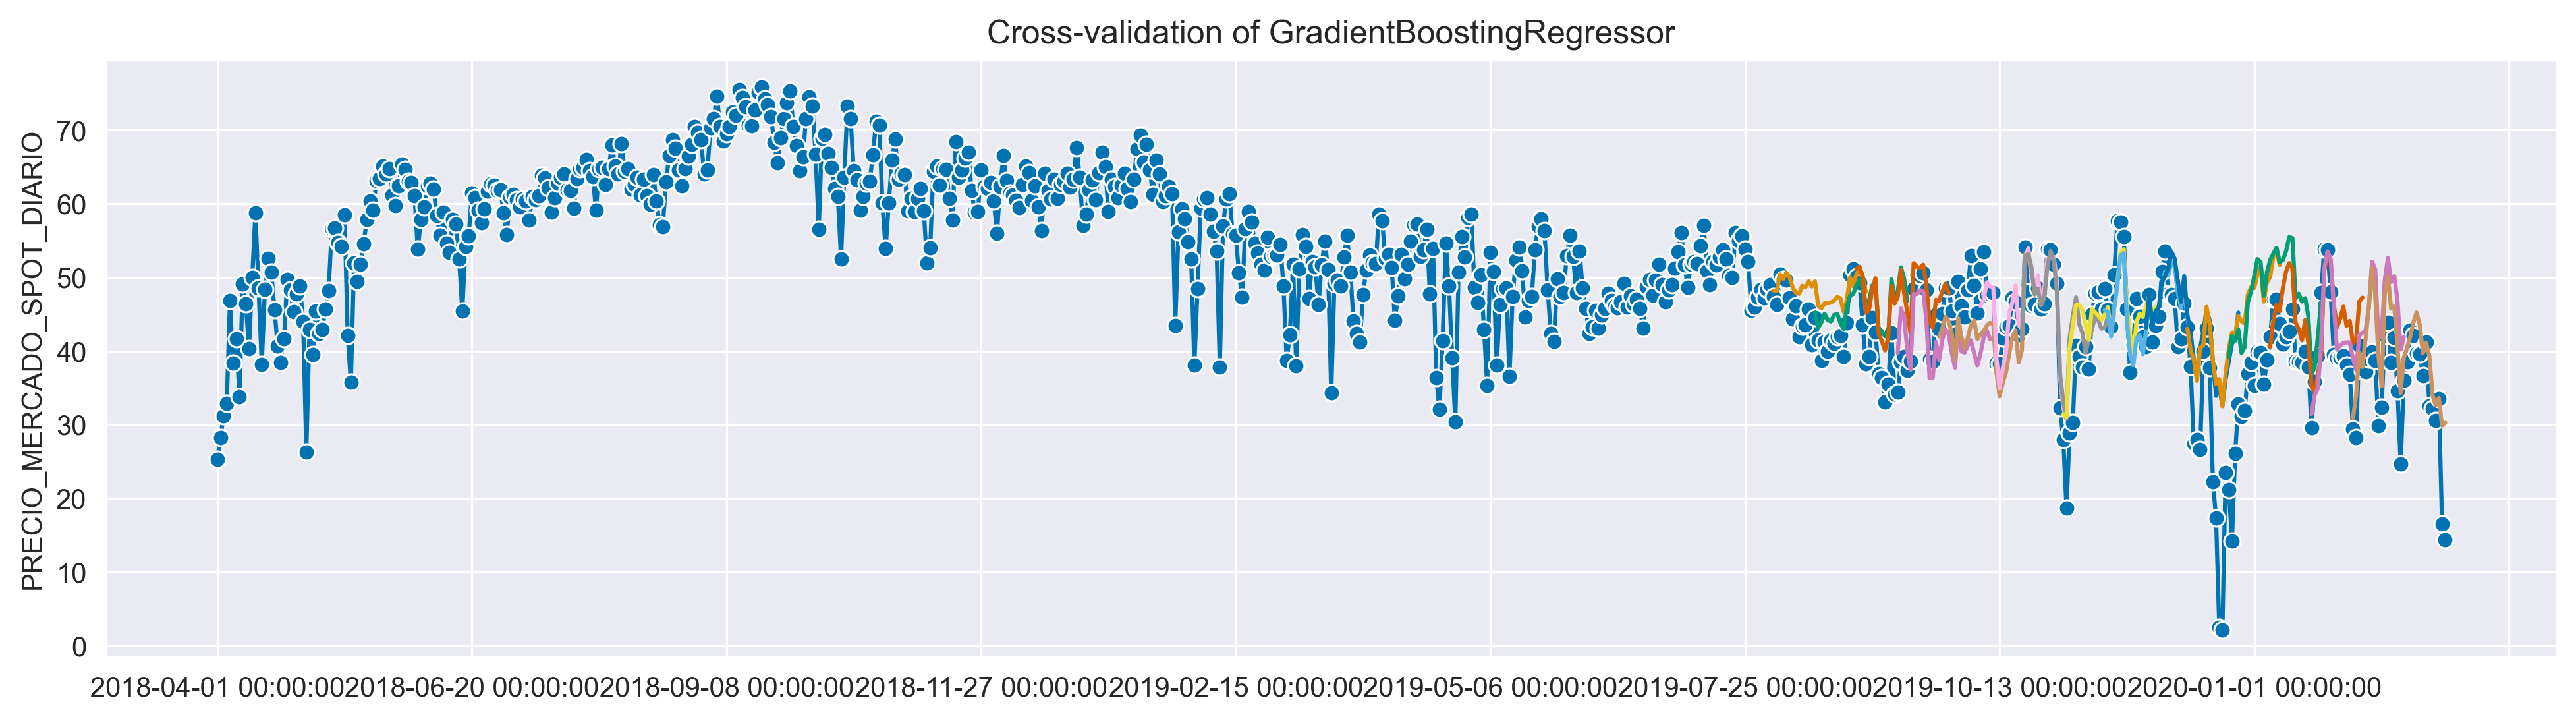

In [8]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [9]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

model  mean_mase  mean_mae  fit_time
2  GradientBoostingRegressor   1.394157  4.802096  6.168062
1      RandomForestRegressor   1.578723  5.445451  3.798591
0        KNeighborsRegressor   2.024368  6.988430  0.264462

In [10]:
save_name="daily_pre.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [11]:
cv_results_df = pd.read_pickle(save_path+save_name)

### Final model

In [12]:
data_train_iso, data_test_iso = func.remove_outliers_isolation_forests_train_test(data_train, data_test, columns=[column for column in data_train.columns if column not in date_features])

In [13]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]

forecaster = ForecasterAutoreg(
                 regressor     = best_model,
                 lags          = lags
             )

forecaster.fit(
    y       = data_train_iso.iloc[:, 0],
    exog    = data_train_iso.iloc[:, 1:],
)

In [14]:
y_pred = forecaster.predict(
    steps   = forecasting_horizon,
    exog    = data_test_iso.iloc[:, 1:]
)

y_pred = pd.Series(data=y_pred, index=data_test_iso.iloc[:, 0].index)

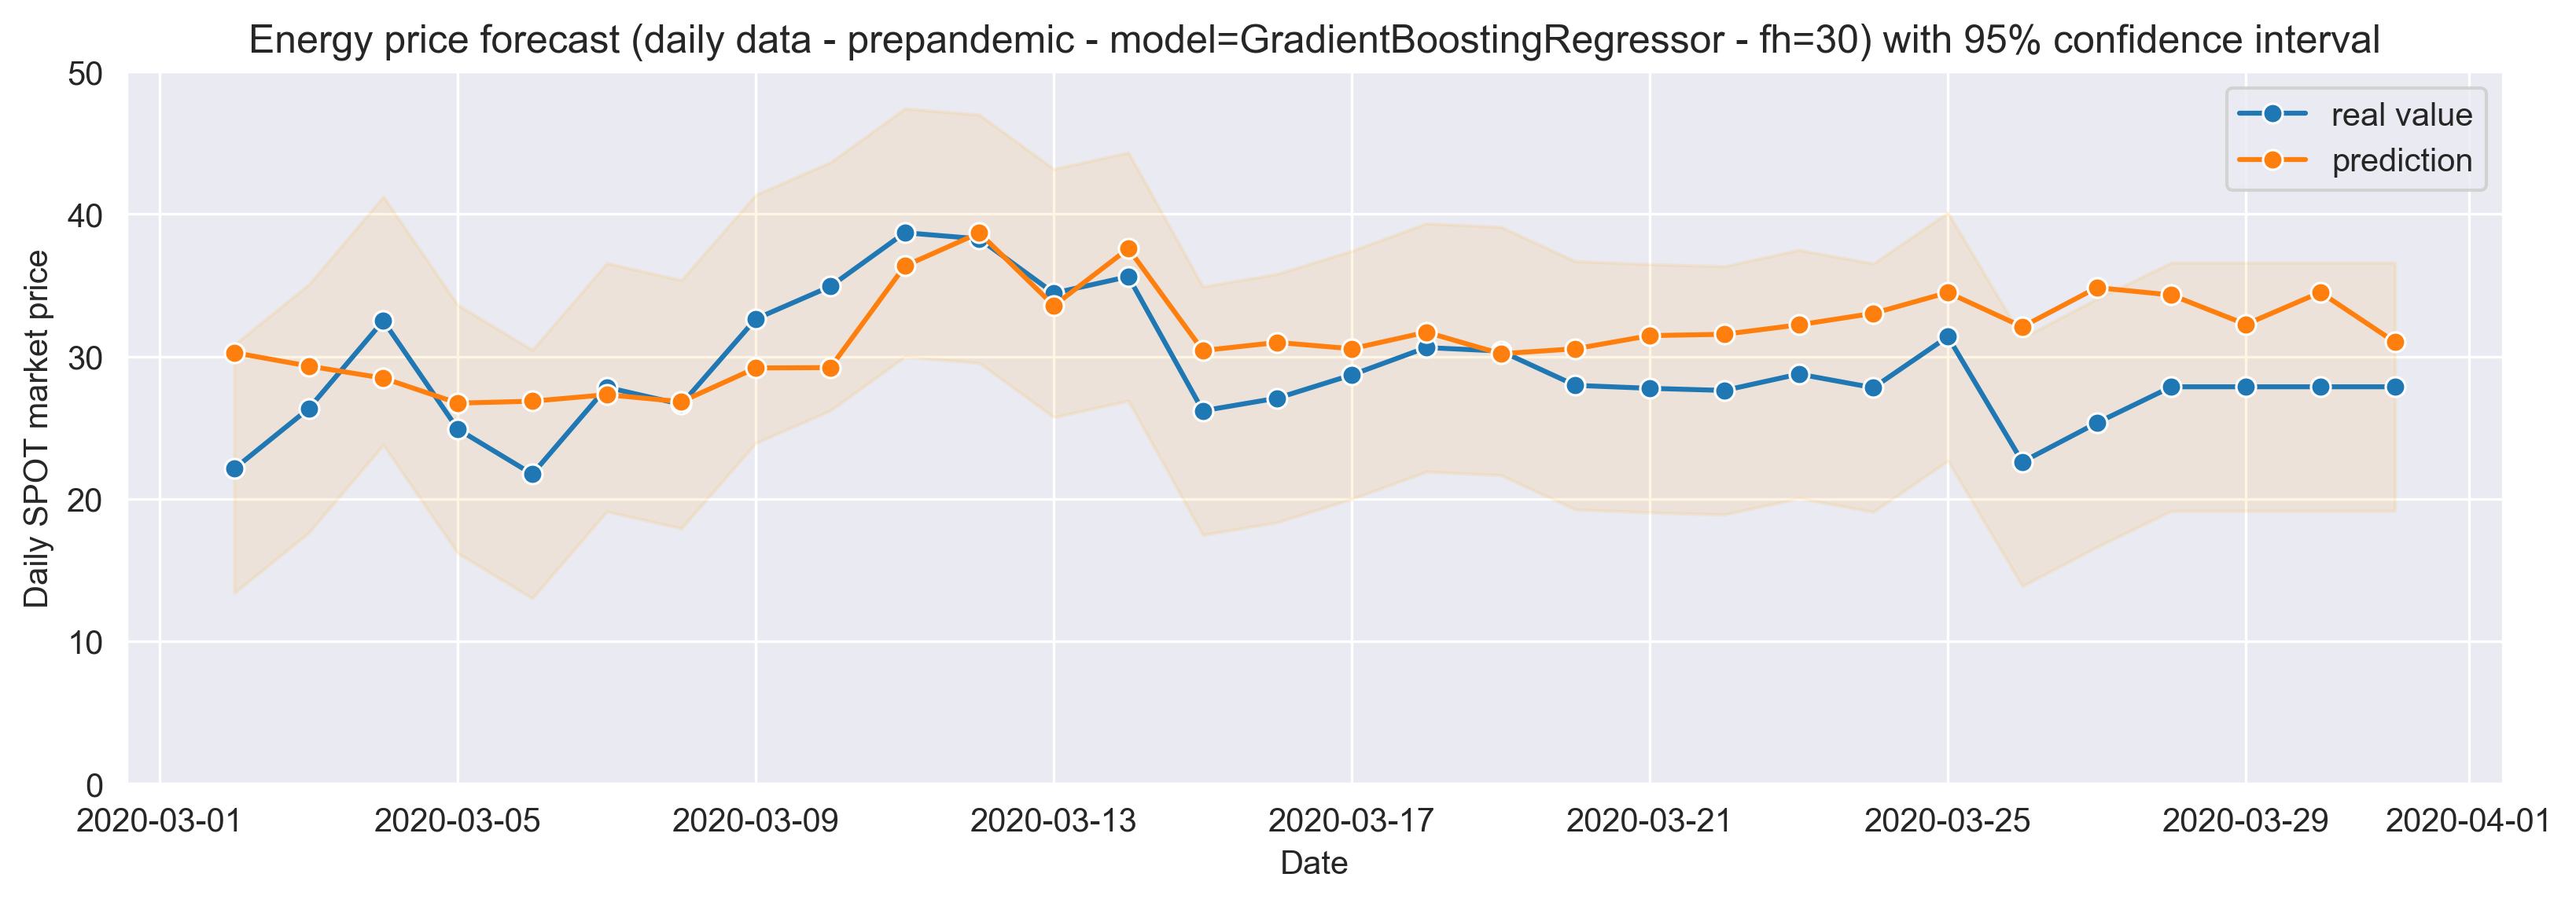

In [15]:
residuals = abs(y_pred-data_test_iso.iloc[:, 0])
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(data_test_iso.iloc[:, 0].index) is pd.core.indexes.period.PeriodIndex:
    data_test_iso.iloc[:, 0].index = data_test_iso.iloc[:, 0].index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(13,4))
sns.lineplot(data=data_test_iso.iloc[:, 0], palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(data_test_iso.iloc[:, 0].index, (data_test_iso.iloc[:, 0]-band_size), (data_test_iso.iloc[:, 0]+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
ax.set_ylim([0,50])
ax.legend(loc="upper right", labels=["real value", "prediction"])
plt.show()

## Postpandemic

In [16]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2021-04-01", end_index="2023-03-31", date_features=date_features)
print(initial_window_length)

518


weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


Model: KNeighborsRegressor
MASEs: [0.9608117670129579, 1.5720113355334882, 2.0203081921155284, 2.169662052252296, 2.2473781600480067, 2.6409540001512726, 3.1816661090670775, 3.7445038552150534, 4.409175276064871, 5.2103934468305875, 4.702441629168848, 4.293529560098804, 4.437394382276509, 2.7173236127458336, 2.264860743590171]
MAEs: [14.877275000000001, 23.98577777777778, 30.63498888888889, 33.5819, 35.846611111111116, 42.72318611111111, 52.269980555555556, 61.57840638888889, 72.58629666666667, 86.20902916666665, 78.25508472222221, 71.68683111111112, 75.72274916666665, 46.75292833333332, 39.3719662037037]
Fit time: 0.28342676162719727

Model: RandomForestRegressor
MASEs: [1.148698471195463, 1.7488629293748754, 2.5751844830631048, 2.172812611390594, 2.195939385850149, 2.525019739750698, 1.4566912057619403, 1.3600354051796464, 2.0848578111637077, 2.8942293952849347, 2.9151507073640337, 2.594991529437939, 1.201563548820459, 1.5388590779502036, 0.6108252657705143]
MAEs: [17.786525555555574

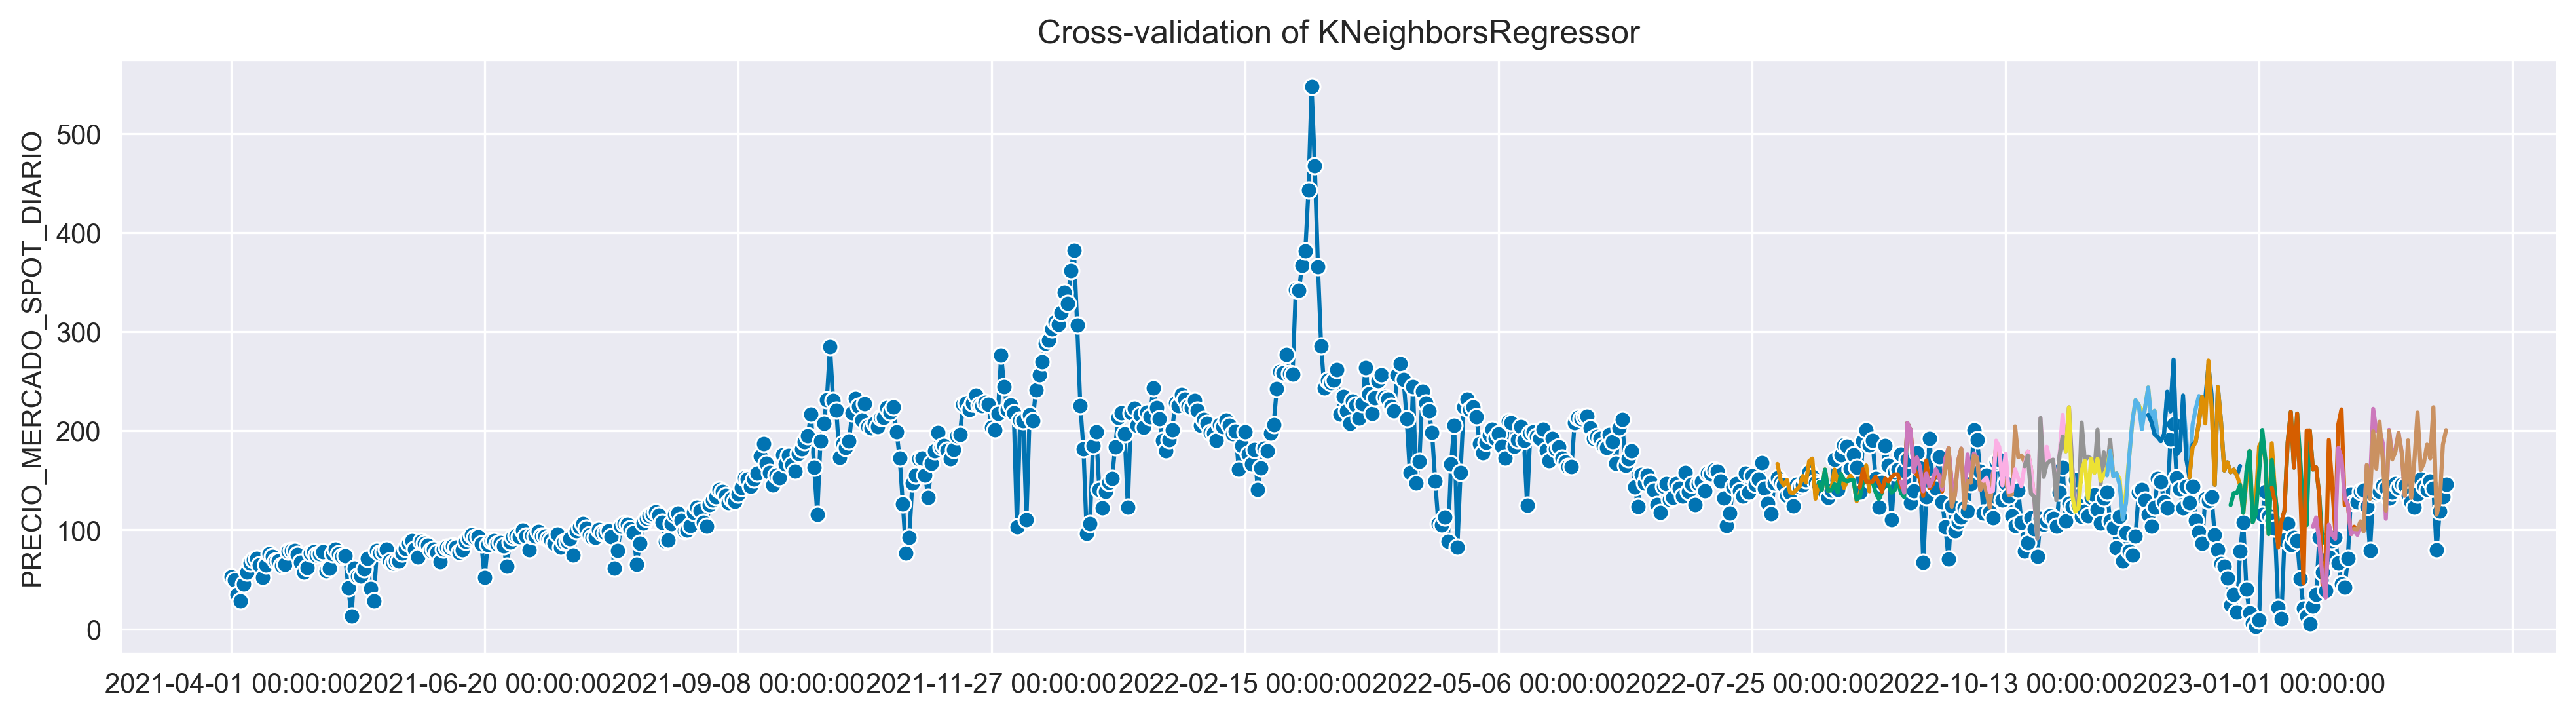

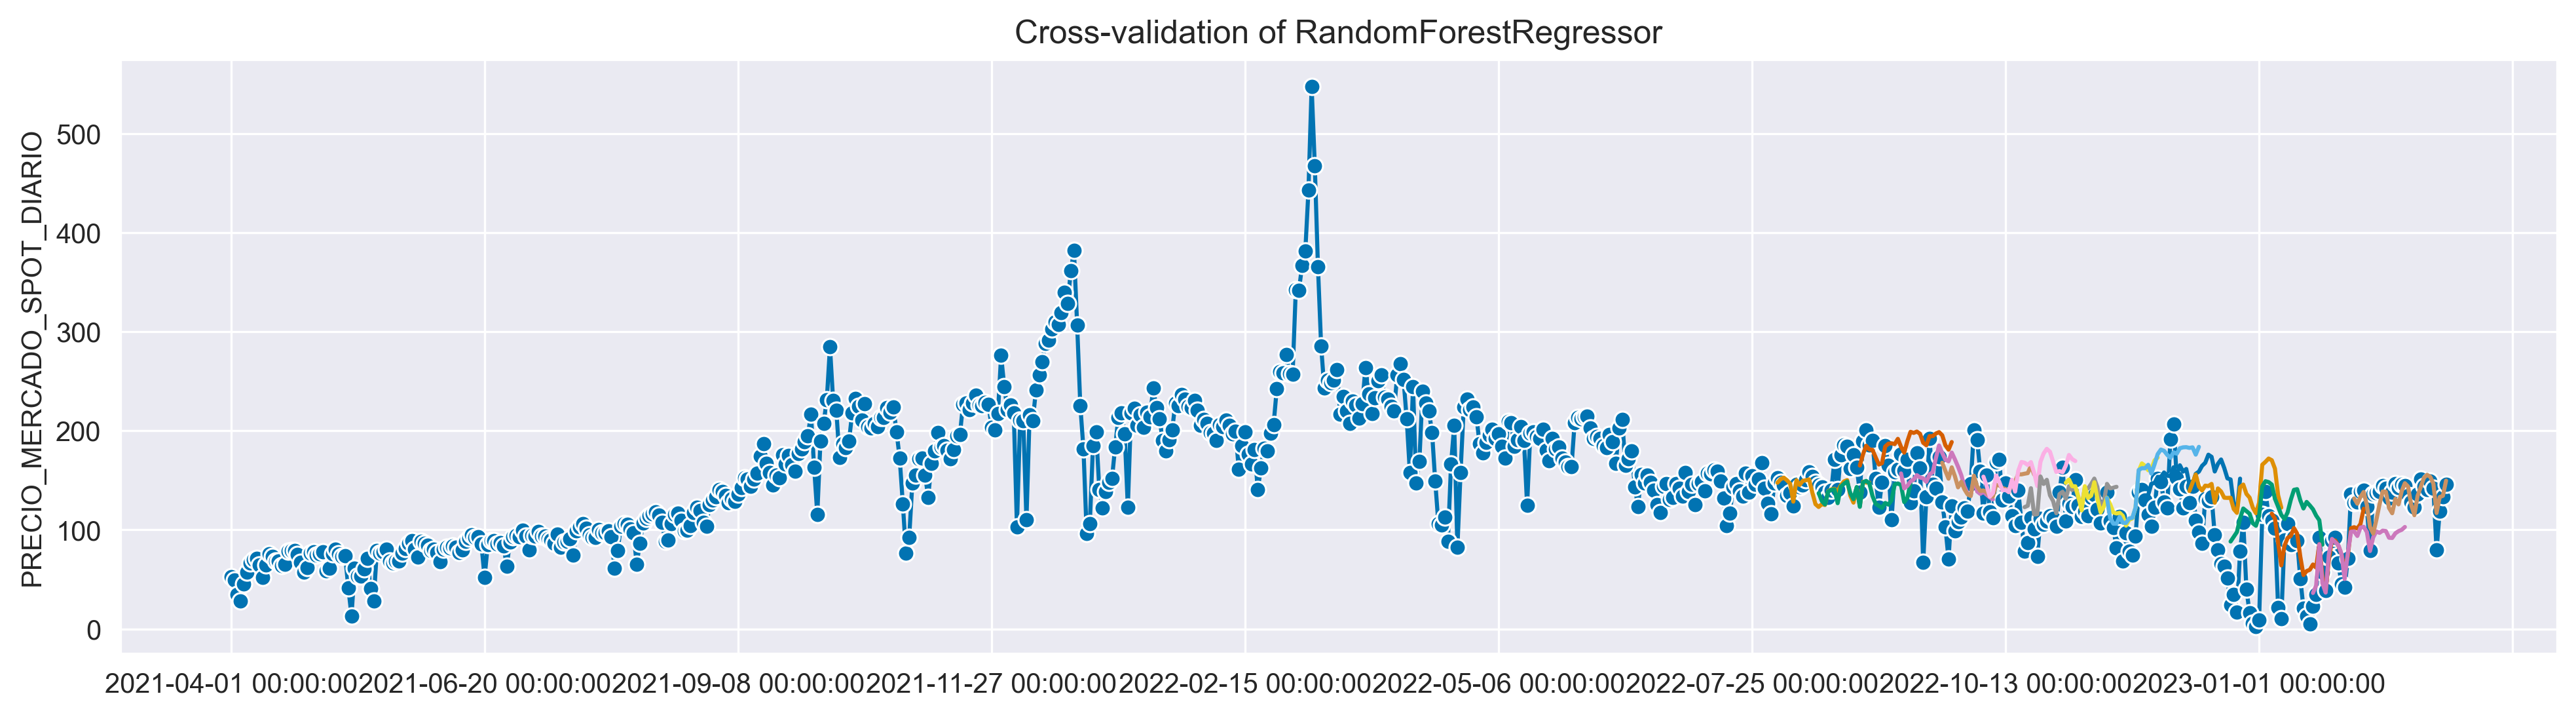

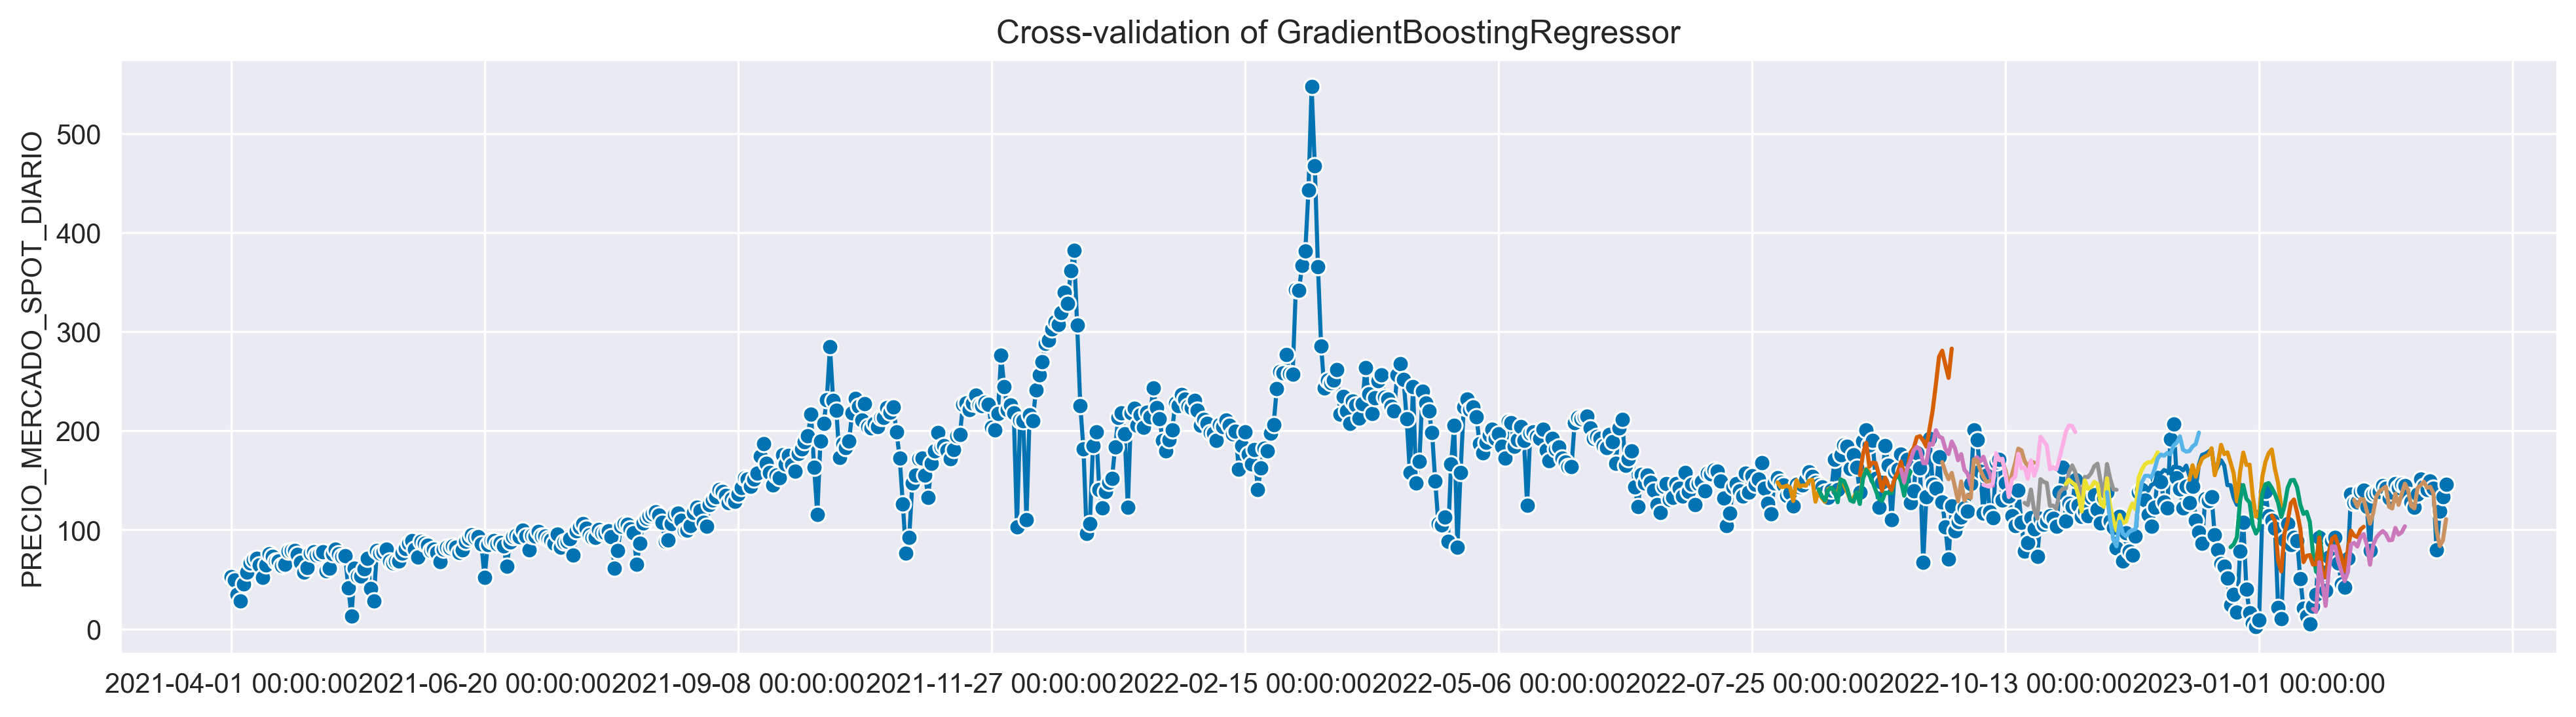

In [17]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [18]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

model  mean_mase   mean_mae  fit_time
1      RandomForestRegressor   1.934915  31.397928  4.724359
2  GradientBoostingRegressor   2.153142  34.947964  4.976181
0        KNeighborsRegressor   3.104828  51.072201  0.283427

In [19]:
save_name="daily_post.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [20]:
cv_results_df = pd.read_pickle(save_path+save_name)

### Final model

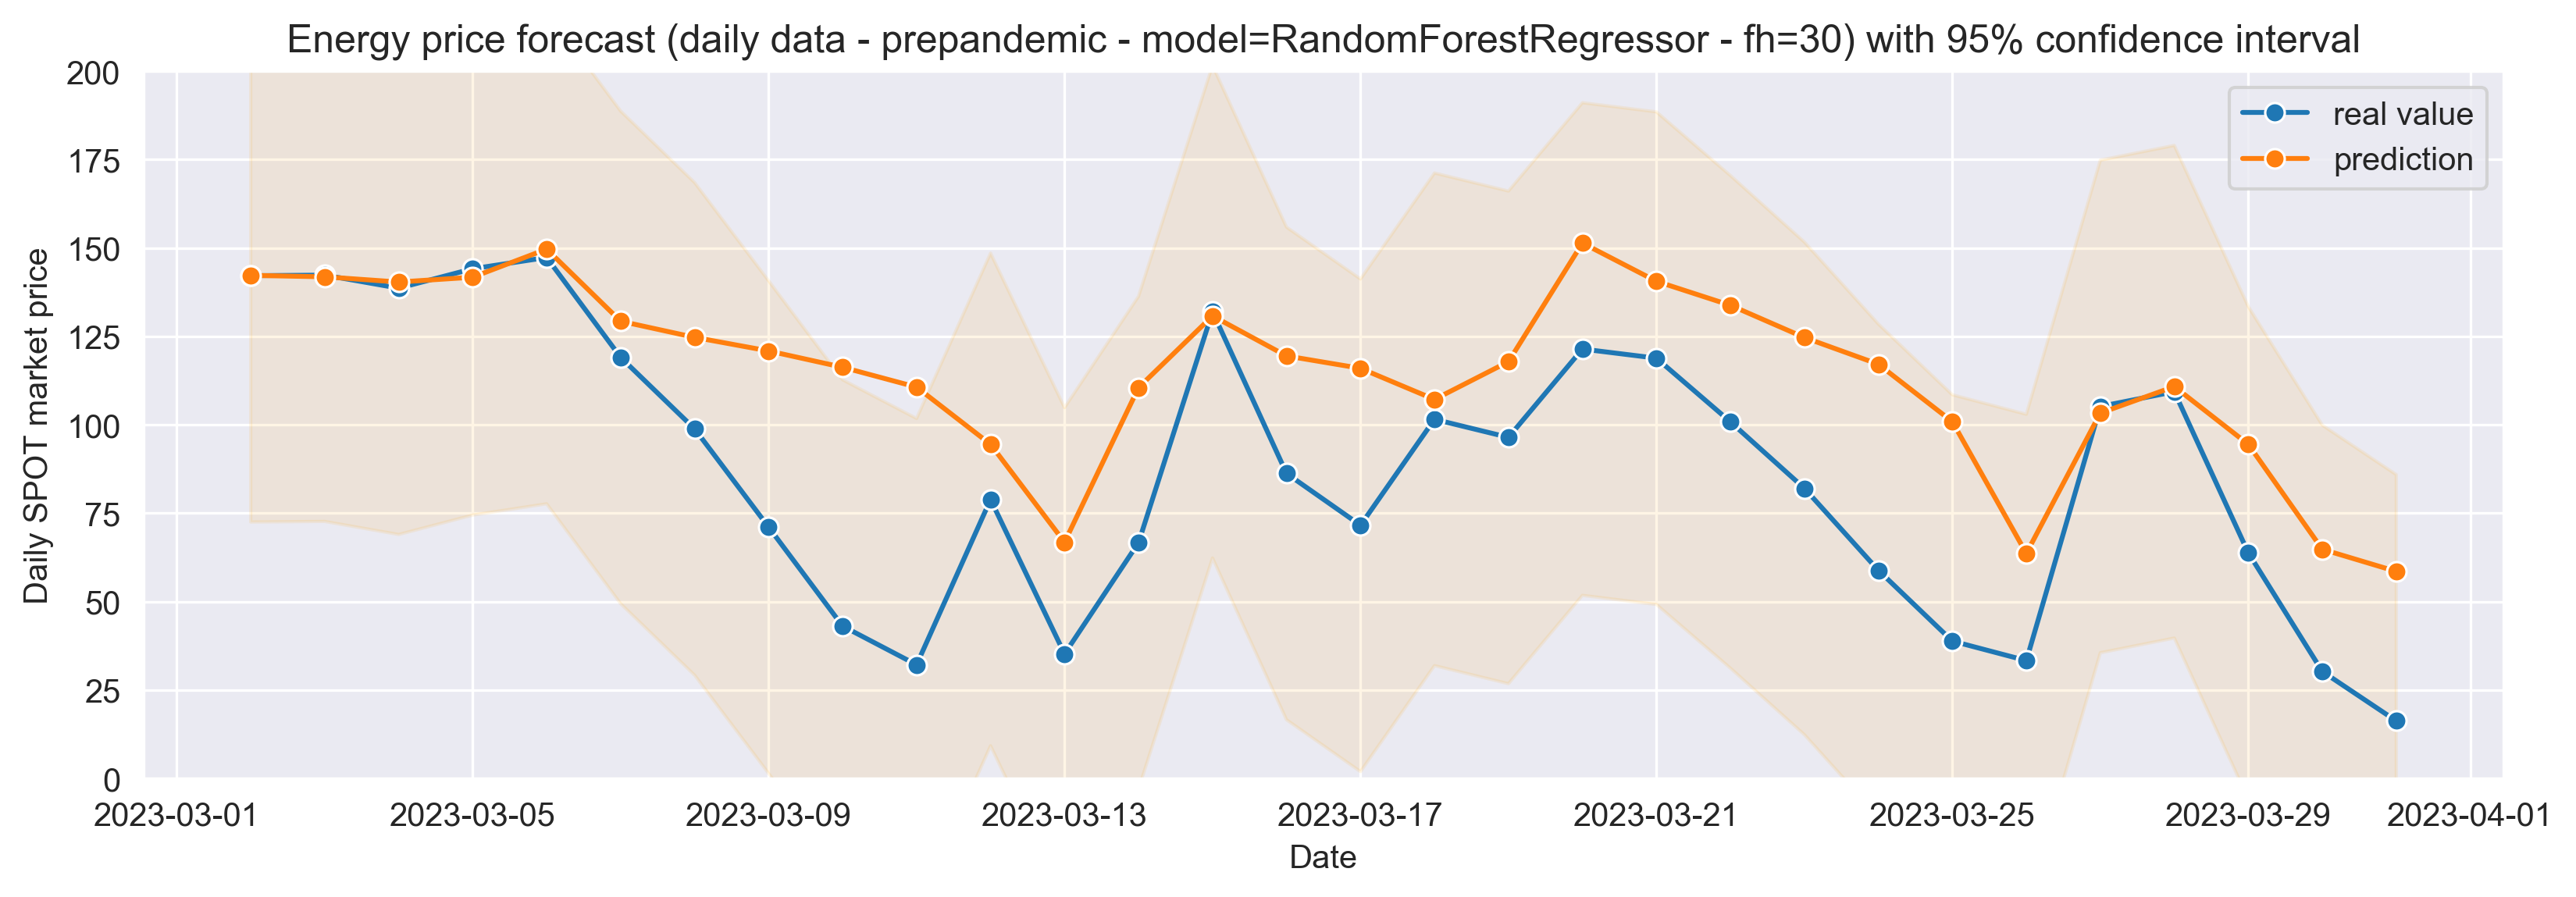

In [21]:
data_train_iso, data_test_iso = func.remove_outliers_isolation_forests_train_test(data_train, data_test,
                                                                             columns=[column for column in
                                                                                      data_train.columns if
                                                                                      column not in date_features])
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]

forecaster = ForecasterAutoreg(
    regressor=best_model,
    lags=lags
)

forecaster.fit(
    y=data_train_iso.iloc[:, 0],
    exog=data_train_iso.iloc[:, 1:],
)
y_pred = forecaster.predict(
    steps=forecasting_horizon,
    exog=data_test_iso.iloc[:, 1:]
)

y_pred = pd.Series(data=y_pred, index=data_test_iso.iloc[:, 0].index)
residuals = abs(y_pred - data_test_iso.iloc[:, 0])
RMSFE = np.sqrt(sum([x ** 2 for x in residuals]) / len(residuals))
band_size = 1.96 * RMSFE

if type(data_test_iso.iloc[:, 0].index) is pd.core.indexes.period.PeriodIndex:
    data_test_iso.iloc[:, 0].index = data_test_iso.iloc[:, 0].index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(13, 4))
sns.lineplot(data=data_test_iso.iloc[:, 0], palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(data_test_iso.iloc[:, 0].index, (data_test_iso.iloc[:, 0] - band_size),
                (data_test_iso.iloc[:, 0] + band_size), color='orange', alpha=.1)
ax.set_title(
    f"Energy price forecast (daily data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
ax.set_ylim([0, 200])
ax.legend(loc="upper right", labels=["real value", "prediction"])
plt.show()